In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

In [2]:
# Set memory management env variable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cpu


In [5]:
# === DATA LOADING AND PREPROCESSING ===
def load_and_preprocess_data(csv_folder, sequence_length=64, test_size=0.2):
    all_data = []
    for file in os.listdir(csv_folder):
        if file.endswith(".csv"):
            file_path = os.path.join(csv_folder, file)
            df = pd.read_csv(file_path, usecols=[0, 1, 2, 3])  # Voltage, Current, Time, SOC
            all_data.append(df)

    df = pd.concat(all_data, ignore_index=True)
    
    scaler_x = StandardScaler()
    df.iloc[:, [0, 1, 2]] = scaler_x.fit_transform(df.iloc[:, [0, 1, 2]])

    data = df.iloc[:, [0, 1, 2]].values  # Features (Voltage, Current, Time)
    labels = df.iloc[:, 3].values  # SOC target

    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(labels[i])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test, scaler_x

In [7]:
# === LSTM-ATTENTION MODEL DEFINITION ===
class LSTM_Attention_SOC(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, num_heads=4, dropout=0.2):
        super(LSTM_Attention_SOC, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, 
                                               dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        out = self.fc(attn_out[:, -1, :])
        return out

In [9]:
# === TRANSFORMER MODEL DEFINITION ===
class TransformerSOC(nn.Module):
    def __init__(self, input_size=3, d_model=32, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerSOC, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 64, d_model))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_projection(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x


In [11]:
# === TRAINING FUNCTION FOR LSTM-ATTENTION ===
def train_lstm_attention(X_train, y_train, X_test, y_test,
                         input_size=3, hidden_size=32, num_layers=2, num_heads=4, 
                         num_epochs=30, batch_size=16, learning_rate=0.00015, patience=5):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = LSTM_Attention_SOC(input_size, hidden_size, num_layers, num_heads).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    print("\n🔄 Training LSTM-Attention Model on", device, "...\n")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                total_test_loss += loss.item()
            avg_test_loss = total_test_loss / len(test_dataloader)
            test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

        # Early stopping
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
            print(f"📈 New best test loss: {best_test_loss:.6f}, saving model state...")
        else:
            epochs_no_improve += 1
            print(f"No improvement in test loss for {epochs_no_improve} epochs")

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} with best test loss: {best_test_loss:.6f}")
            break

        # Learning rate scheduling
        scheduler.step(avg_test_loss)

        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Load the best model state
    model.load_state_dict(best_model_state)
    print("\n✅ LSTM-Attention Training Complete with Early Stopping!\n")

    model.eval()
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, _ in test_dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            y_test_pred_list.append(y_pred.cpu().numpy())
    
    y_test_pred = np.concatenate(y_test_pred_list, axis=0)

    return model, train_losses, test_losses, y_test_pred, best_test_loss


In [13]:
# === TRAINING FUNCTION FOR TRANSFORMER ===
def train_transformer(X_train, y_train, X_test, y_test, input_size=3, d_model=32, nhead=4, num_layers=2, num_epochs=30, batch_size=16, learning_rate=1e-4, patience=5):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = TransformerSOC(input_size, d_model, nhead, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    print("\n🔄 Training Transformer Model on", device, "...\n")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                total_test_loss += loss.item()
            avg_test_loss = total_test_loss / len(test_dataloader)
            test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

        # Early stopping
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
            print(f"📈 New best test loss: {best_test_loss:.6f}, saving model state...")
        else:
            epochs_no_improve += 1
            print(f"No improvement in test loss for {epochs_no_improve} epochs")

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} with best test loss: {best_test_loss:.6f}")
            break

        # Learning rate scheduling
        scheduler.step(avg_test_loss)

        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Load the best model state
    model.load_state_dict(best_model_state)
    print("\n✅ Transformer Training Complete with Early Stopping!\n")

    model.eval()
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, _ in test_dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            y_test_pred_list.append(y_pred.cpu().numpy())
    
    y_test_pred = np.concatenate(y_test_pred_list, axis=0)

    return model, train_losses, test_losses, y_test_pred, best_test_loss

X_train shape: (469995, 64, 3), y_train shape: (469995,)
X_test shape: (117499, 64, 3), y_test shape: (117499,)
📁 Scaler saved to scaler_x.pkl


C:\Users\AK\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔄 Training LSTM-Attention Model on cpu ...

Epoch [1/30] - Train Loss: 0.003302, Test Loss: 0.000794
📈 New best test loss: 0.000794, saving model state...
Epoch [2/30] - Train Loss: 0.000328, Test Loss: 0.000358
📈 New best test loss: 0.000358, saving model state...
Epoch [3/30] - Train Loss: 0.000202, Test Loss: 0.000157
📈 New best test loss: 0.000157, saving model state...
Epoch [4/30] - Train Loss: 0.000166, Test Loss: 0.000077
📈 New best test loss: 0.000077, saving model state...
Epoch [5/30] - Train Loss: 0.000152, Test Loss: 0.000050
📈 New best test loss: 0.000050, saving model state...
Epoch [6/30] - Train Loss: 0.000143, Test Loss: 0.000068
No improvement in test loss for 1 epochs
Epoch [7/30] - Train Loss: 0.000135, Test Loss: 0.000065
No improvement in test loss for 2 epochs
Epoch [8/30] - Train Loss: 0.000129, Test Loss: 0.000059
No improvement in test loss for 3 epochs
Epoch [9/30] - Train Loss: 0.000125, Test Loss: 0.000047
📈 New best test loss: 0.000047, saving model stat

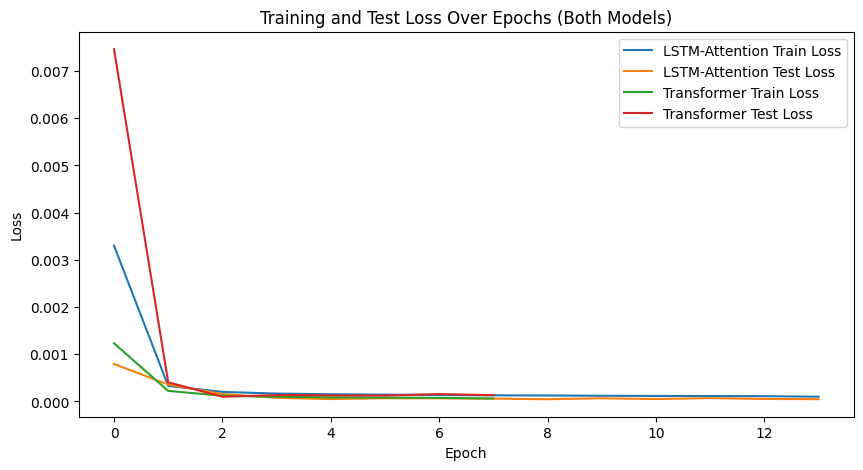

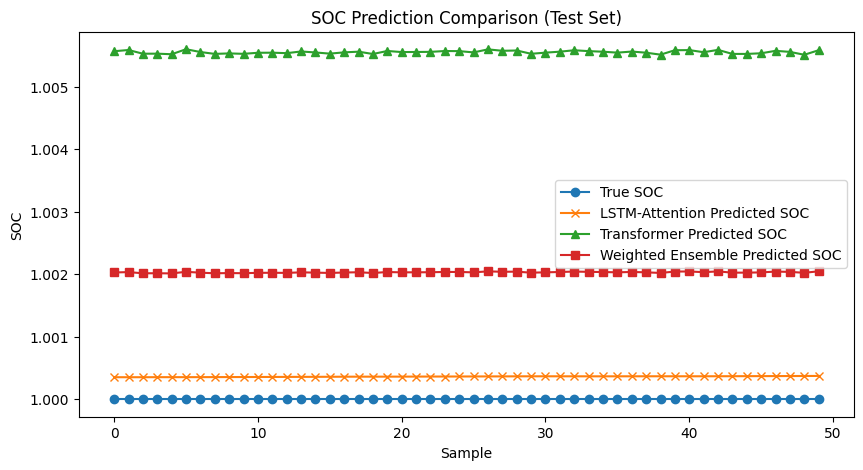

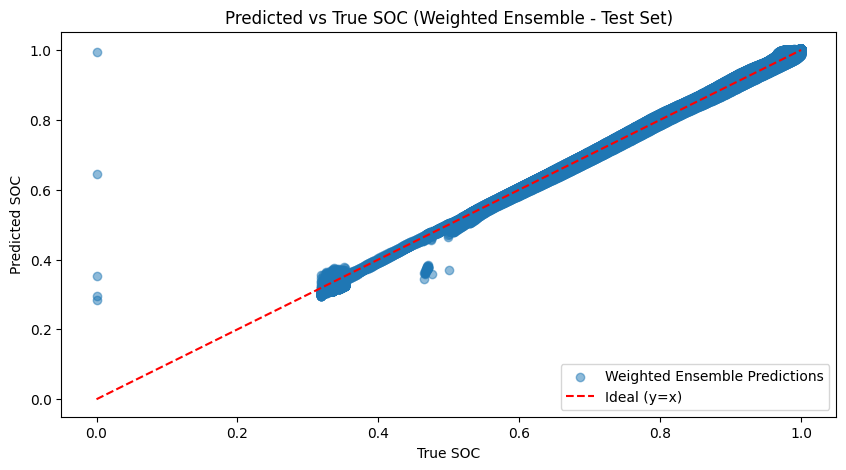

In [15]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    csv_folder = r"C:\Users\AK\Desktop\Model_comparison\processed_csv_files_reduced"

    # Load and preprocess data
    X_train, X_test, y_train, y_test, scaler_x = load_and_preprocess_data(csv_folder)

    # Save the scaler
    joblib.dump(scaler_x, "scaler_x.pkl")
    print("📁 Scaler saved to scaler_x.pkl")

    # Train LSTM-Attention model
    lstm_model, lstm_train_losses, lstm_test_losses, lstm_y_test_pred, lstm_best_test_loss = train_lstm_attention(X_train, y_train, X_test, y_test)

    # Save the LSTM-Attention model
    torch.save(lstm_model.state_dict(), "lstm_attention_soc_v2.pkl")
    print("📁 LSTM-Attention model saved to lstm_attention_soc_v2.pkl")

    # Train Transformer model
    transformer_model, transformer_train_losses, transformer_test_losses, transformer_y_test_pred, transformer_best_test_loss = train_transformer(X_train, y_train, X_test, y_test)

    # Save the Transformer model
    torch.save(transformer_model.state_dict(), "transformer_soc_v2.pkl")
    print("📁 Transformer model saved to transformer_soc_v2.pkl")

    # Weighted ensemble based on inverse test losses
    total_loss = lstm_best_test_loss + transformer_best_test_loss
    lstm_weight = (1 / lstm_best_test_loss) / ( (1 / lstm_best_test_loss) + (1 / transformer_best_test_loss) )
    transformer_weight = (1 / transformer_best_test_loss) / ( (1 / lstm_best_test_loss) + (1 / transformer_best_test_loss) )
    print(f"\nEnsemble Weights - LSTM-Attention: {lstm_weight:.4f}, Transformer: {transformer_weight:.4f}")

    ensemble_y_test_pred = lstm_weight * lstm_y_test_pred + transformer_weight * transformer_y_test_pred

    # Evaluate ensemble metrics
    y_test_np = y_test.reshape(-1, 1)
    mse_ensemble = np.mean((ensemble_y_test_pred - y_test_np) ** 2)
    mae_ensemble = np.mean(np.abs(ensemble_y_test_pred - y_test_np))
    rmse_ensemble = np.sqrt(mse_ensemble)

    print(f"\nImproved Ensemble Test Metrics - MSE: {mse_ensemble:.6f}, MAE: {mae_ensemble:.6f}, RMSE: {rmse_ensemble:.6f}")

    # Save losses for both models
    lstm_loss_df = pd.DataFrame({'train_loss': lstm_train_losses, 'test_loss': lstm_test_losses})
    lstm_loss_df.to_csv("lstm_attention_soc_losses_v2.csv", index=False)
    print("📁 LSTM-Attention Losses saved to lstm_attention_soc_losses_v2.csv")

    transformer_loss_df = pd.DataFrame({'train_loss': transformer_train_losses, 'test_loss': transformer_test_losses})
    transformer_loss_df.to_csv("transformer_soc_losses_v2.csv", index=False)
    print("📁 Transformer Losses saved to transformer_soc_losses_v2.csv")

    # Plot learning curves for both models
    plt.figure(figsize=(10, 5))
    plt.plot(lstm_train_losses, label='LSTM-Attention Train Loss')
    plt.plot(lstm_test_losses, label='LSTM-Attention Test Loss')
    plt.plot(transformer_train_losses, label='Transformer Train Loss')
    plt.plot(transformer_test_losses, label='Transformer Test Loss')
    plt.title('Training and Test Loss Over Epochs (Both Models)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('combined_soc_loss_plot_v2.png')
    print("📊 Combined Loss plot saved to combined_soc_loss_plot_v2.png")

    # Plot predictions on test set (first 50 samples) for ensemble
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_np[:50], label='True SOC', marker='o')
    plt.plot(lstm_y_test_pred[:50], label='LSTM-Attention Predicted SOC', marker='x')
    plt.plot(transformer_y_test_pred[:50], label='Transformer Predicted SOC', marker='^')
    plt.plot(ensemble_y_test_pred[:50], label='Weighted Ensemble Predicted SOC', marker='s')
    plt.title('SOC Prediction Comparison (Test Set)')
    plt.xlabel('Sample')
    plt.ylabel('SOC')
    plt.legend()
    plt.savefig('ensemble_soc_predictions_v2.png')
    print("📊 SOC prediction plot saved to ensemble_soc_predictions_v2.png")

    # Plot predicted vs true SOC for ensemble
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, ensemble_y_test_pred, alpha=0.5, label='Weighted Ensemble Predictions')
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y=x)')
    plt.xlabel('True SOC')
    plt.ylabel('Predicted SOC')
    plt.title('Predicted vs True SOC (Weighted Ensemble - Test Set)')
    plt.legend()
    plt.savefig('ensemble_soc_predicted_vs_true_v2.png')
    print("📊 Ensemble Predicted vs True plot saved to ensemble_soc_predicted_vs_true_v2.png")

    if device.type == "cuda":
        torch.cuda.empty_cache()